## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [289]:
import glob

import numpy as np
import scipy as sp
import scipy.io

from matplotlib import pyplot as plt
from scipy.signal import find_peaks


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, pass_band, fs):
    b, a = sp.signal.butter(5, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)
    
def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg_org, accx_org, accy_org, accz_org = LoadTroikaDataFile(data_fl)
    hr_estimates = []
    
    # Compute pulse rate estimates and estimation confidence.
    for end_sec in range(8, 310, 2):
        fs = 125
        begin_idx = (end_sec-8)*fs
        end_idx = end_sec * fs

        #get an 8 second window of data
        ppg = ppg_org[begin_idx:end_idx]
        accx = accx_org[begin_idx:end_idx]
        accy = accy_org[begin_idx:end_idx]
        accz = accz_org[begin_idx:end_idx]
        acc_total = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))

        #apply a bandpass filter
        filtered_ppg = BandpassFilter(ppg, (.5, 4), fs)  #bandpass range is between 30 and 240 bpm

        #perform fourier transform to get into frequency domain
        freqs_ppg = np.fft.rfftfreq(len(filtered_ppg), 1/fs)    # rfftfreq tells us the frequencies for which we are computing the Fourier transform.
        fft_ppg = np.fft.rfft(filtered_ppg)                     # rfft computes the actual Fourier transform coefficients

        #find the peaks.
        ppg_peaks = find_peaks(np.abs(fft_ppg), height = 0, threshold = None, distance = 25)

        #get the frequency of the top peak
        sorted_top_ppg_peak_values = np.argsort(filtered_fft_ppg[ppg_peaks[0]]) 
        top_ppg_peak_magnitudes = np.flip(filtered_fft_ppg[ppg_peaks[0]][sorted_top_ppg_peak_values])
        top_ppg_peak_frequencies = np.flip(freqs_ppg[ppg_peaks[0]][sorted_top_ppg_peak_values])

        #computer the HR
        hr = 60 * top_ppg_peak_frequencies[0]
        hr_estimates.append(hr)

    print(hr_estimates)
    
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors, confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    return errors, confidence

In [291]:
data_files, reference_files = LoadTroikaDataset()
for data_fl, ref_fl in zip(data_files, reference_files):
    RunPulseRateAlgorithm(data_fl, ref_fl)


[75.0, 75.0, 75.0, 75.0, 75.0, 67.5, 75.0, 75.0, 75.0, 75.0, 75.0, 82.5, 52.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 105.0, 165.0, 165.0, 157.5, 157.5, 157.5, 157.5, 157.5, 157.5, 157.5, 157.5, 157.5, 157.5, 157.5, 157.5, 150.0, 150.0, 157.5, 157.5, 157.5, 157.5, 157.5, 157.5, 157.5, 150.0, 165.0, 165.0, 165.0, 165.0, 165.0, 330.0, 337.5, 322.5, 135.0, 165.0, 397.5, 367.5, 367.5, 172.5, 180.0, 172.5, 360.0, 367.5, 360.0, 390.0, 172.5, 367.5, 172.5, 360.0, 360.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 157.5, 157.5, 165.0, 165.0, 165.0, 165.0, 165.0, 165.0, 165.0, 165.0, 165.0, 157.5, 157.5, 157.5, 165.0, 165.0, 165.0, 165.0, 165.0, 165.0, 165.0, 165.0, 165.0, 142.5, 142.5, 142.5, 165.0, 150.0, 150.0, 180.0, 180.0, 375.0, 367.5, 172.5, 360.0, 172.5, 375.0, 172.5, 360.0, 360.0, 180.0, 180.0, 367.5, 180.0, 165.0, 165.0, 90.0, 90.0, 90.0, 180.0, 180.0, 180.0, 180.0, 90.0, 90.0, 172.5, 172.5, 367.5, 172.5, 187.5, 82.5, 165.0, 165.0, 157.5, 157.5, 157.5, 157.5, 157.5, 15

ValueError: The length of the input vector x must be greater than padlen, which is 33.

loading:  ./datasets/troika/training_data/DATA_03_TYPE02.mat


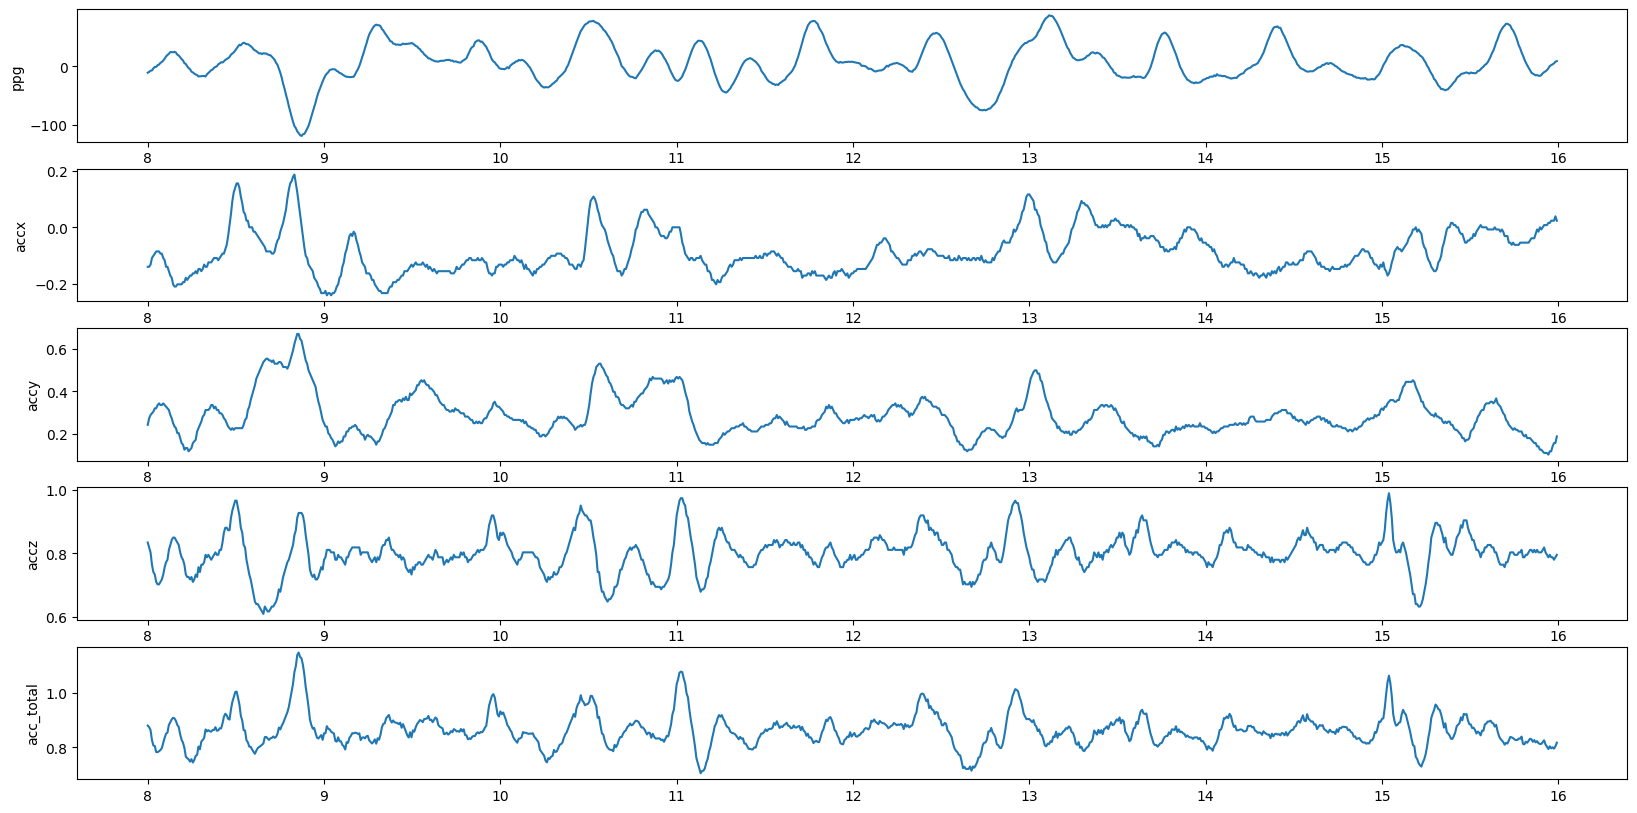

In [3]:
data_files, reference_files = LoadTroikaDataset()
#print(data_files)
#print(reference_files)

data_file = data_files[2]
print("loading: ", data_file)
sig_data = LoadTroikaDataFile(data_file)
ppg, accx, accy, accz = LoadTroikaDataFile(data_file)
acc_total = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))

fs = 125  
ts = np.arange(len(accx)) / fs

fig, axes = plt.subplots(5, 1, figsize=(20, 10))

begin_idx = 1000
end_idx = 2000

axes[0].plot(ts[begin_idx:end_idx], ppg[begin_idx:end_idx])
axes[0].set_ylabel("ppg")

axes[1].plot(ts[begin_idx:end_idx], accx[begin_idx:end_idx])
axes[1].set_ylabel("accx")

axes[2].plot(ts[begin_idx:end_idx], accy[begin_idx:end_idx])
axes[2].set_ylabel("accy")

axes[3].plot(ts[begin_idx:end_idx], accz[begin_idx:end_idx])
axes[3].set_ylabel("accz")

axes[4].plot(ts[begin_idx:end_idx], acc_total[begin_idx:end_idx])
axes[4].set_ylabel("acc_total")

plt.show()


loading:  ./datasets/troika/training_data/DATA_02_TYPE02.mat
(37850,)


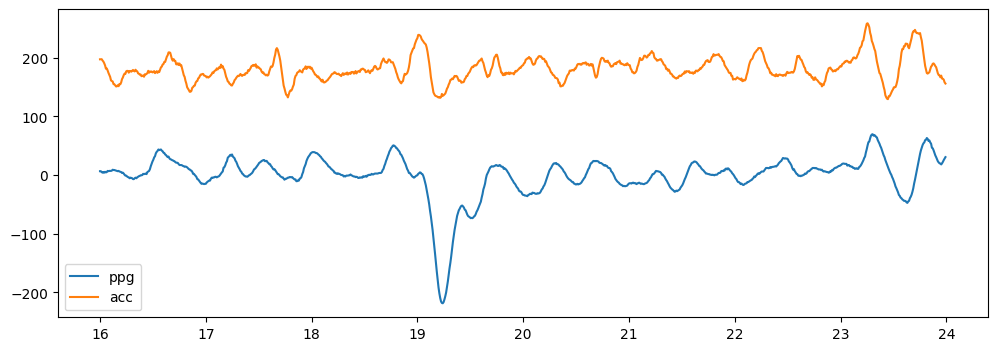

In [288]:
data_file = data_files[1]
print("loading: ", data_file)
sig_data = LoadTroikaDataFile(data_file)
ppg, accx, accy, accz = LoadTroikaDataFile(data_file)
#print(ppg.shape)  #37850

#grab an 8 second time window 
begin_second = 16
begin_idx = begin_second*fs
end_idx = (8+begin_second)*fs

ppg = ppg[begin_idx:end_idx]
accx = accx[begin_idx:end_idx]
accy = accy[begin_idx:end_idx]
accz = accz[begin_idx:end_idx]

acc_total = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))
acc_total = acc_total

plt.figure(figsize=(12, 4))
plt.plot(ts[begin_idx:end_idx], ppg, label='ppg')
plt.plot(ts[begin_idx:end_idx], 200*acc_total, label='acc')
plt.legend()

loading:  ./datasets/troika/training_data/DATA_02_TYPE02.mat
(1000,)
(1000,)
(1000,)


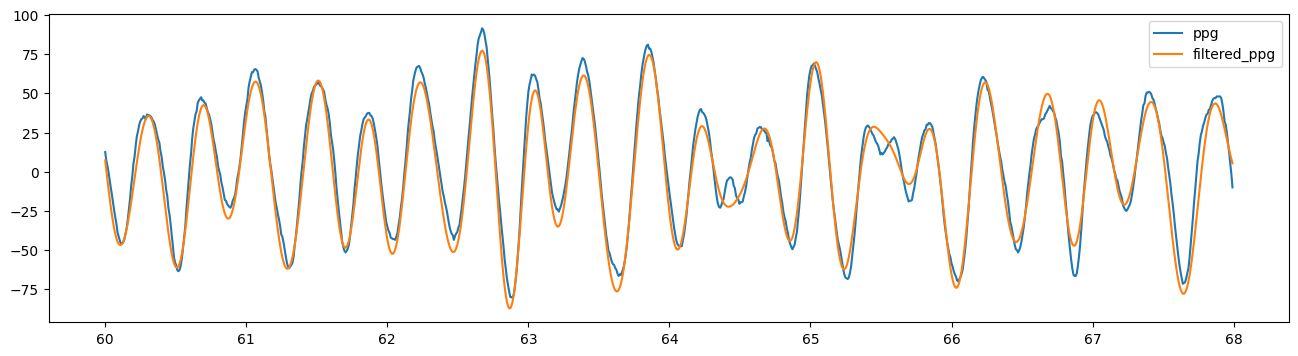

In [279]:
# *************************************************
data_file = data_files[1]
print("loading: ", data_file)
sig_data = LoadTroikaDataFile(data_file)
ppg, accx, accy, accz = LoadTroikaDataFile(data_file)

#grab an 8 second time window 
begin_second = 60
begin_idx = begin_second*fs
end_idx = (8+begin_second)*fs

ppg = ppg[begin_idx:end_idx]
accx = accx[begin_idx:end_idx]
accy = accy[begin_idx:end_idx]
accz = accz[begin_idx:end_idx]

acc_total = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))



filtered_ppg = BandpassFilter(ppg, (.5, 4), fs)  #bandpass range is between 30 and 240 bpm

print(ts[begin_idx:end_idx].shape)
print(ppg.shape)
print(filtered_ppg.shape)

plt.figure(figsize=(16, 4))
plt.plot(ts[begin_idx:end_idx],          ppg, label='ppg')
plt.plot(ts[begin_idx:end_idx], filtered_ppg, label='filtered_ppg')
plt.legend()

Text(0.5, 0, 'Frequency (Hz)')

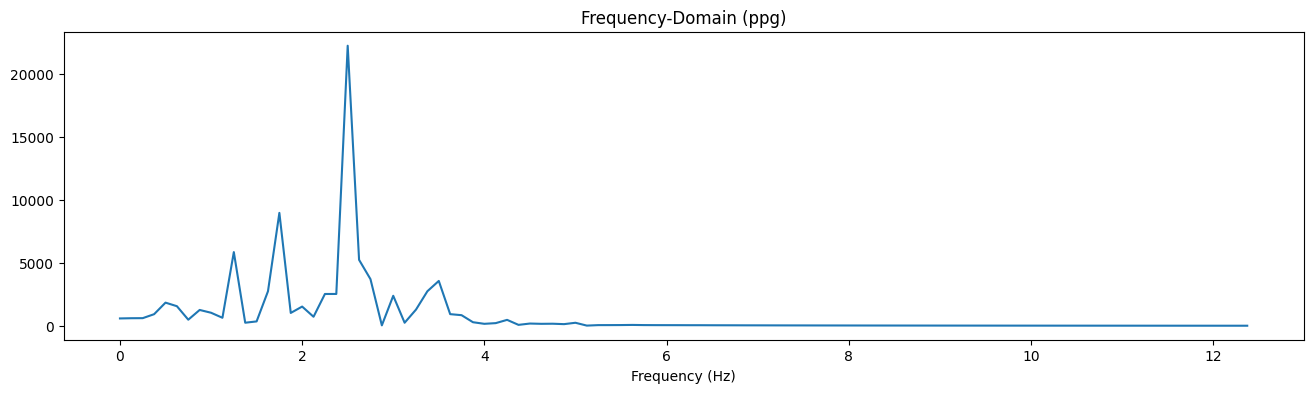

In [280]:
#apply fft to determine HR

freqs_ppg = np.fft.rfftfreq(len(filtered_ppg), 1/fs)    # rfftfreq tells us the frequencies for which we are computing the Fourier transform.
fft_ppg = np.fft.rfft(filtered_ppg)                     # rfft computes the actual Fourier transform coefficients

plt.figure(figsize=(16, 4))
plt.plot(freqs_ppg[0:100], np.abs(fft_ppg)[0:100])
plt.title('Frequency-Domain (ppg)')
plt.xlabel('Frequency (Hz)')

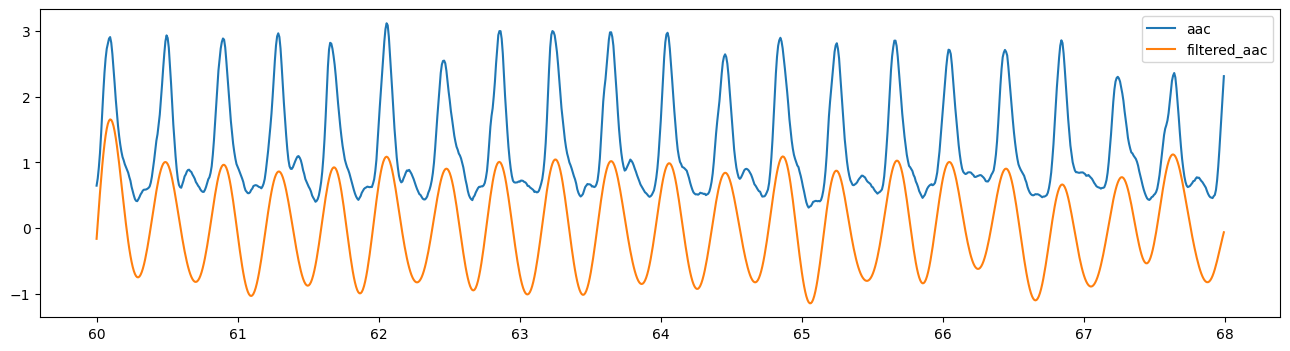

In [281]:
filtered_acc_total = BandpassFilter(acc_total, (.5, 4), fs)  #bandpass range is between 30 and 240 bpm

plt.figure(figsize=(16, 4))
plt.plot(ts[begin_idx:end_idx],          acc_total, label='aac')
plt.plot(ts[begin_idx:end_idx], filtered_acc_total, label='filtered_aac')
plt.legend()

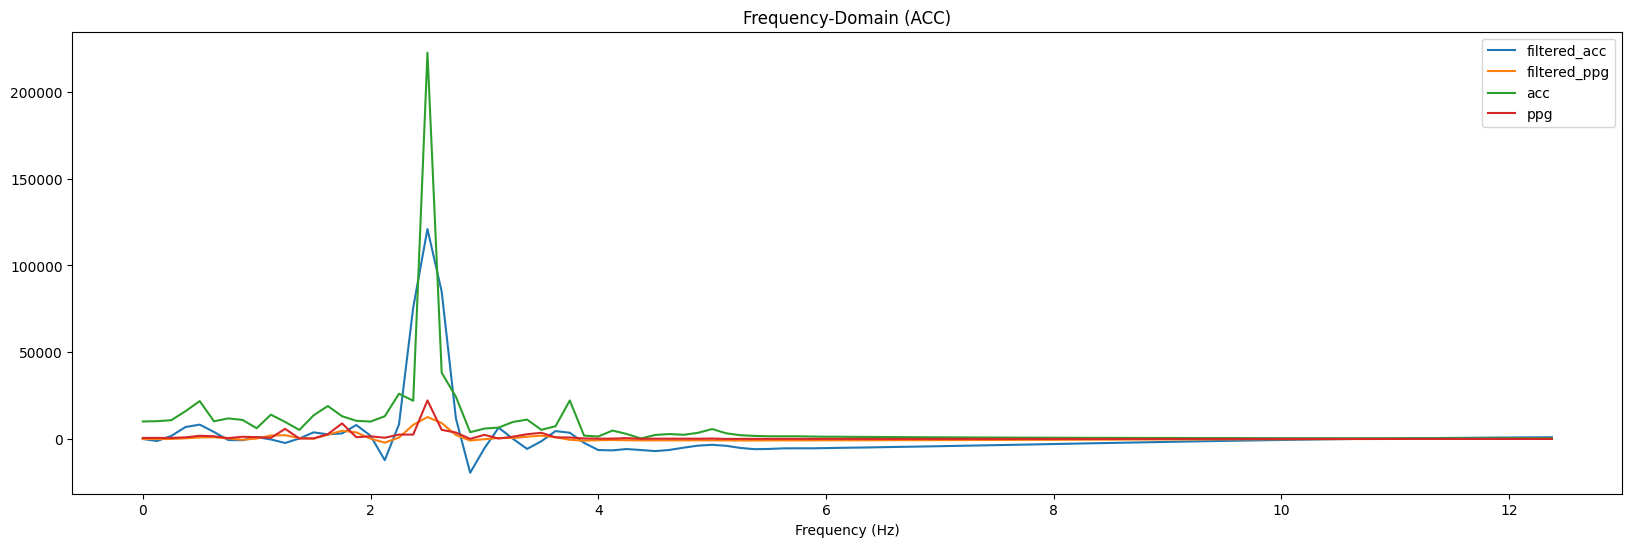

In [282]:
#apply fft to determine frequencies that may interfere with HR PPG measurement

freqs_acc = np.fft.rfftfreq(len(filtered_acc_total), 1/fs)    # rfftfreq tells us the frequencies for which we are computing the Fourier transform.
fft_acc   = np.fft.rfft(filtered_acc_total)                     # rfft computes the actual Fourier transform coefficients

filtered_fft_acc = BandpassFilter(np.abs(fft_acc), (1, 32), fs)  #bandpass range is between 30 and 240 bpm
filtered_fft_ppg = BandpassFilter(np.abs(fft_ppg), (1, 32), fs)  #bandpass range is between 30 and 240 bpm

plt.figure(figsize=(20, 6))
plt.plot(freqs_acc[0:100], 500*filtered_fft_acc[0:100], label='filtered_acc')
plt.plot(freqs_ppg[0:100], filtered_fft_ppg[0:100], label='filtered_ppg')
plt.plot(freqs_acc[0:100], 500*np.abs(fft_acc)[0:100], label='acc')
plt.plot(freqs_ppg[0:100], np.abs(fft_ppg)[0:100], label='ppg')
plt.title('Frequency-Domain (ACC)')
plt.xlabel('Frequency (Hz)')
plt.legend()

peak ppg indices [20 45]
peak ppg magnitudes [12643.94594052  -805.10323398]
peak ppg frequencies [2.5   5.625]
peak acc indices [20 46]
peak acc magnitudes [242.01086833 -10.71580083]
peak acc frequencies [2.5  5.75]


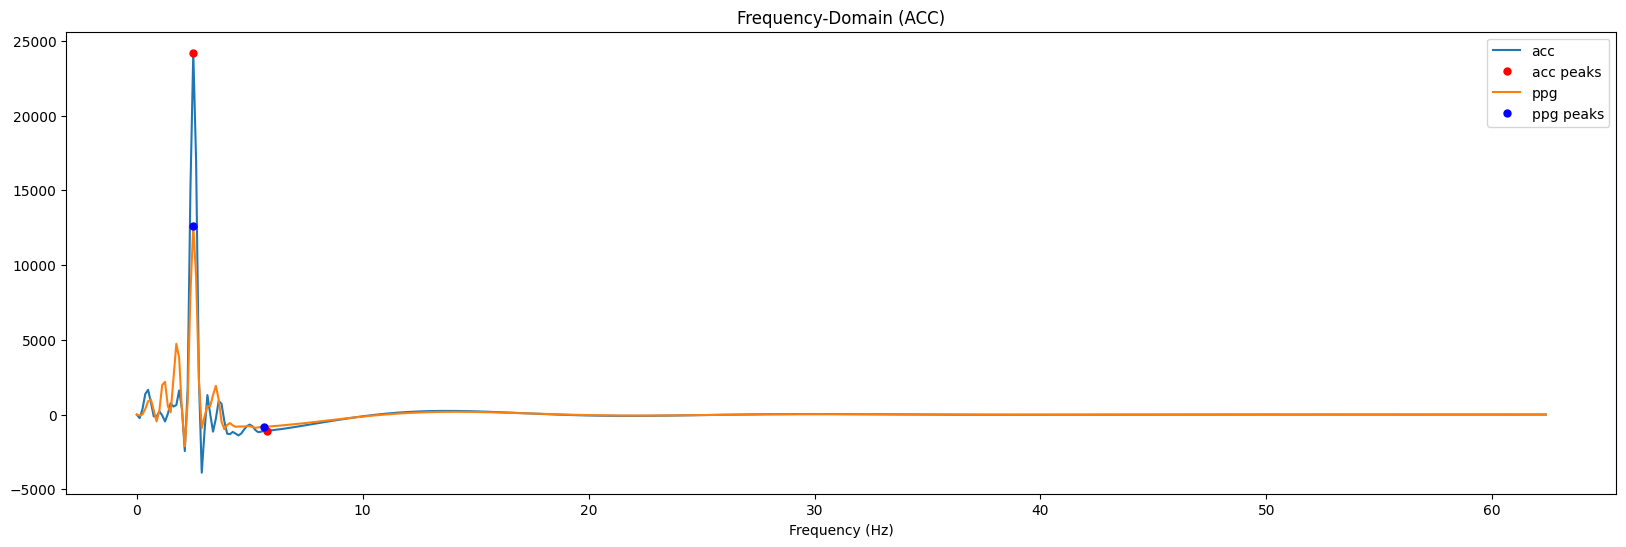

In [283]:
from scipy.signal import find_peaks
# acc_peaks = find_peaks(filtered_fft_acc, height = 0, threshold = None, distance = 25)
# ppg_peaks = find_peaks(filtered_fft_ppg, height = 0, threshold = None, distance = 25)
acc_peaks = find_peaks(np.abs(fft_acc), height = 0, threshold = None, distance = 25)
ppg_peaks = find_peaks(np.abs(fft_ppg), height = 0, threshold = None, distance = 25)

#print("acc_peaks", acc_peaks)
print("peak ppg indices", ppg_peaks[0])
print("peak ppg magnitudes", filtered_fft_ppg[ppg_peaks[0]])
print("peak ppg frequencies", freqs_ppg[ppg_peaks[0]])
print("peak acc indices", acc_peaks[0])
print("peak acc magnitudes", filtered_fft_acc[acc_peaks[0]])
print("peak acc frequencies", freqs_acc[acc_peaks[0]])

plt.figure(figsize=(20, 6))
plt.plot(freqs_acc[0:500], filtered_fft_acc[0:500]*100, label='acc')
plt.plot(freqs_acc[acc_peaks[0]], filtered_fft_acc[acc_peaks[0]]*100, 'r.', ms=10, label='acc peaks')

plt.plot(freqs_ppg[0:500], filtered_fft_ppg[0:500], label='ppg')
plt.plot(freqs_ppg[ppg_peaks[0]], filtered_fft_ppg[ppg_peaks[0]], 'b.', ms=10, label='ppg peaks')
plt.title('Frequency-Domain (ACC)')
plt.xlabel('Frequency (Hz)')
plt.legend()

In [284]:
#The top indices of the ppg sensor
sorted_top_ppg_peak_values = np.argsort(filtered_fft_ppg[ppg_peaks[0]]) 

top_ppg_peak_magnitudes = np.flip(filtered_fft_ppg[ppg_peaks[0]][sorted_top_ppg_peak_values])
top_ppg_peak_frequencies = np.flip(freqs_ppg[ppg_peaks[0]][sorted_top_ppg_peak_values])

#print("top_acc_peak_magnitudes", top_acc_peak_magnitudes)
print("top_ppg_peak_frequencies", top_ppg_peak_frequencies)

hr = 60 * top_ppg_peak_frequencies[0]
print("hr (min): ", hr * .85)
print("hr: ", hr)
print("hr (max): ", hr * 1.15)


top_ppg_peak_frequencies [2.5   5.625]
hr (min):  127.5
hr:  150.0
hr (max):  172.5


In [285]:
def FindPeaks(signal, order=10):
    """A simple peak detection algorithm."""
    msk = (signal[order:-order] > signal[:-order * 2]) & (signal[order:-order] > signal[order * 2:])
    for o in range(1, order):
        msk &= (signal[order:-order] > signal[o: -order * 2 + o])
        msk &= (signal[order:-order] > signal[order * 2 - o: -o])
    return msk.nonzero()[0] + order

print(FindPeaks(filtered_fft_acc[0:1500], order=100))

[]


In [286]:
#The task - find the peak (blue dot in the chart above) that does not have a corresponding acc peak (top 3 red dots)

#The top indices of the acc sensor
sorted_top_acc_peak_values = np.argsort(filtered_fft_acc[acc_peaks[0]]) 

top_acc_peak_magnitudes = np.flip(filtered_fft_acc[acc_peaks[0]][sorted_top_acc_peak_values])
top_acc_peak_frequencies = np.flip(freqs_acc[acc_peaks[0]][sorted_top_acc_peak_values])

#print("top_acc_peak_magnitudes", top_acc_peak_magnitudes)
print("top_acc_peak_frequencies", top_acc_peak_frequencies)

#The top indices of the ppg sensor
sorted_top_ppg_peak_values = np.argsort(filtered_fft_ppg[ppg_peaks[0]]) 

top_ppg_peak_magnitudes = np.flip(filtered_fft_ppg[ppg_peaks[0]][sorted_top_ppg_peak_values])
top_ppg_peak_frequencies = np.flip(freqs_ppg[ppg_peaks[0]][sorted_top_ppg_peak_values])

#print("top_ppg_peak_magnitudes", top_ppg_peak_magnitudes)
print("top_ppg_peak_frequencies", top_ppg_peak_frequencies)

def find_hr_freq_from_ppg_and_acc(top_ppg_peak_frequencies, top_acc_peak_frequencies):
    hr_freq = 0
    for ppg_freq in top_ppg_peak_frequencies:
        print("testing ppg_freq:", ppg_freq)
        counter = 0
        skip_ppg_freq = False
        for aac_freq in top_acc_peak_frequencies:
            counter += 1
            if counter > 3:
                break
            if ppg_freq > aac_freq*.94 and ppg_freq < aac_freq*1.07:
                skip_ppg_freq = True
        if not skip_ppg_freq:
            hr_freq = ppg_freq
            break

    return hr_freq

hr_freq = find_hr_freq_from_ppg_and_acc(top_ppg_peak_frequencies, top_acc_peak_frequencies)
hr_bpm = hr_freq * 60
print("hr_freq = {}, hr_bpm = {}".format(hr_freq, hr_bpm))
            
            



top_acc_peak_frequencies [2.5  5.75]
top_ppg_peak_frequencies [2.5   5.625]
testing ppg_freq: 2.5
testing ppg_freq: 5.625
hr_freq = 0, hr_bpm = 0


In [287]:
data_files, reference_files = LoadTroikaDataset()
#print(data_files)
#print(reference_files)

data_file = reference_files[1]
print("loading: ", data_file)
ref_data = sp.io.loadmat(data_file)
print(ref_data)

loading:  ./datasets/troika/training_data/REF_02_TYPE02.mat
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Aug 12 01:06:15 2014', '__version__': '1.0', '__globals__': [], 'BPM0': array([[ 84.74576271],
       [ 89.77149075],
       [ 92.59259259],
       [ 88.99676375],
       [ 84.36445444],
       [ 81.2567714 ],
       [ 76.09921082],
       [ 72.90400972],
       [ 72.11538462],
       [ 70.92198582],
       [ 74.58563536],
       [ 76.79180887],
       [ 73.932092  ],
       [ 73.05194805],
       [ 71.77033493],
       [ 69.51596292],
       [ 73.44940152],
       [ 78.04370447],
       [ 84.35582822],
       [ 90.75907591],
       [ 93.53741497],
       [ 94.82758621],
       [ 96.35974304],
       [ 97.2972973 ],
       [ 98.68421053],
       [101.14107884],
       [103.68663594],
       [104.83870968],
       [104.95156082],
       [104.05549626],
       [103.83386581],
       [103.39342524],
       [103.39342524],
       [103.32950631],
       [103.2

In [ ]:
#find the top X peaks in both the PPG and ACC frequency domains.
#go through the PPG peaks from largest to smallest


-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 